### Laboratorium 6 - zadania

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Zadanie

Dany jest obraz `pills`. Wykorzystaj transformację Hougha do detekcji linii, aby wykryć krawędzie między komórkami organizera. Wykorzystaj ulubiony detektor krawędzi i zaprezentuj wyniki pośrednie przed użyciem transformacji Hougha. Zapoznaj się z dokumentacją funkcji [`cv2.HoughLines`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a), zwłaszcza parametrami sterującymi rozdzielczością `rho`, `theta` oraz progiem `threshold` i przeanalizuj ich wpływ na osiągane wyniki.

Zacznij od znalezienia odpowiednich parametrów detektora krawędzi - jeśli na tym etapie wyniki będą słabe, to dalej będzie tylko gorzej (_garbage-in, garbage-out_) - ale nie skupiaj się na badaniu ich wpływu na wyniki.

Ostateczny rezultat zaprezentuj w postaci linii naniesionych na kopię obrazu wejściowego.

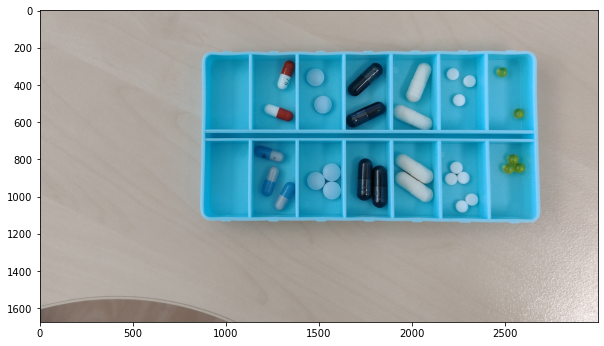

In [2]:
pills = cv2.imread('Lab 5 - dane-20221024/calib.png')
plt.imshow(cv2.cvtColor(pills, cv2.COLOR_BGR2RGB))
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

In [3]:
def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

Rozwiązanie:

1. Znalezienie pudełka i zcroppowanie
2. Znalezienie krawędzi na obrazie przy użyciu canny
3. Odfiltrowanie krawędzi nie pudełka przy użyciu maski tabletek

In [74]:
def plot_canny_ablation(img, mask):
    t1s = [60, 70, 80, 90, 100]
    deltas = [10, 20, 30, 40]

    fig, axes = plt.subplots(len(t1s), len(deltas), figsize=(30, 20))

    for t1, axi in zip(t1s, axes):
        for delta, ax in zip(deltas, axi):
            canny = cv2.Canny(img, threshold1=t1, threshold2=t1 + delta) 
            canny_masked = canny * mask

            ax.imshow(canny_masked)
            ax.set_title(f"Canny: ({t1}, {t1 + delta})")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def crop_box(org_image: np.ndarray, border: int = 25):
    """Detects box and crops an image to it"""
    image = org_image.copy()

    # Otsu threshold on saturation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 1].astype(np.uint8)
    th, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Binary closing of holes
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (300, 300))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    # Contour finding and cropping (box - maximal area contour)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
    x, y, w, h = cv2.boundingRect(contours[0])
    roi = org_image[y + border : y + h - border, x + border : x + w - border]

    return roi

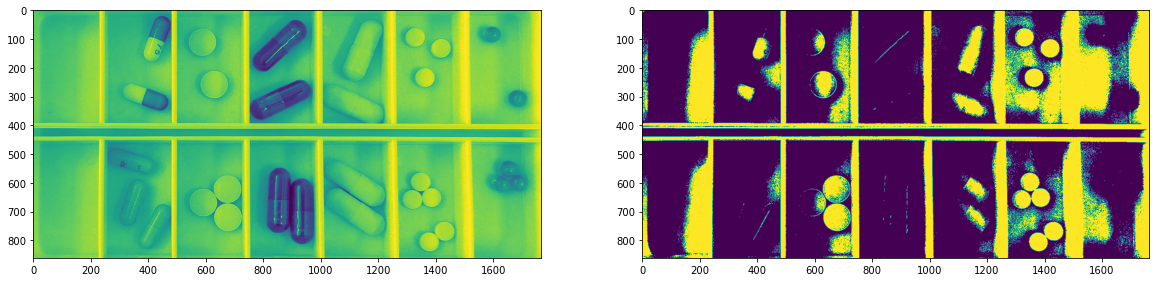

In [79]:
pills_c = crop_box(pills)
pills_v = cv2.cvtColor(pills_c, cv2.COLOR_BGR2HSV)[..., 2]
pills_mask = pills_v > 200

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(pills_v)
axes[1].imshow(pills_mask)

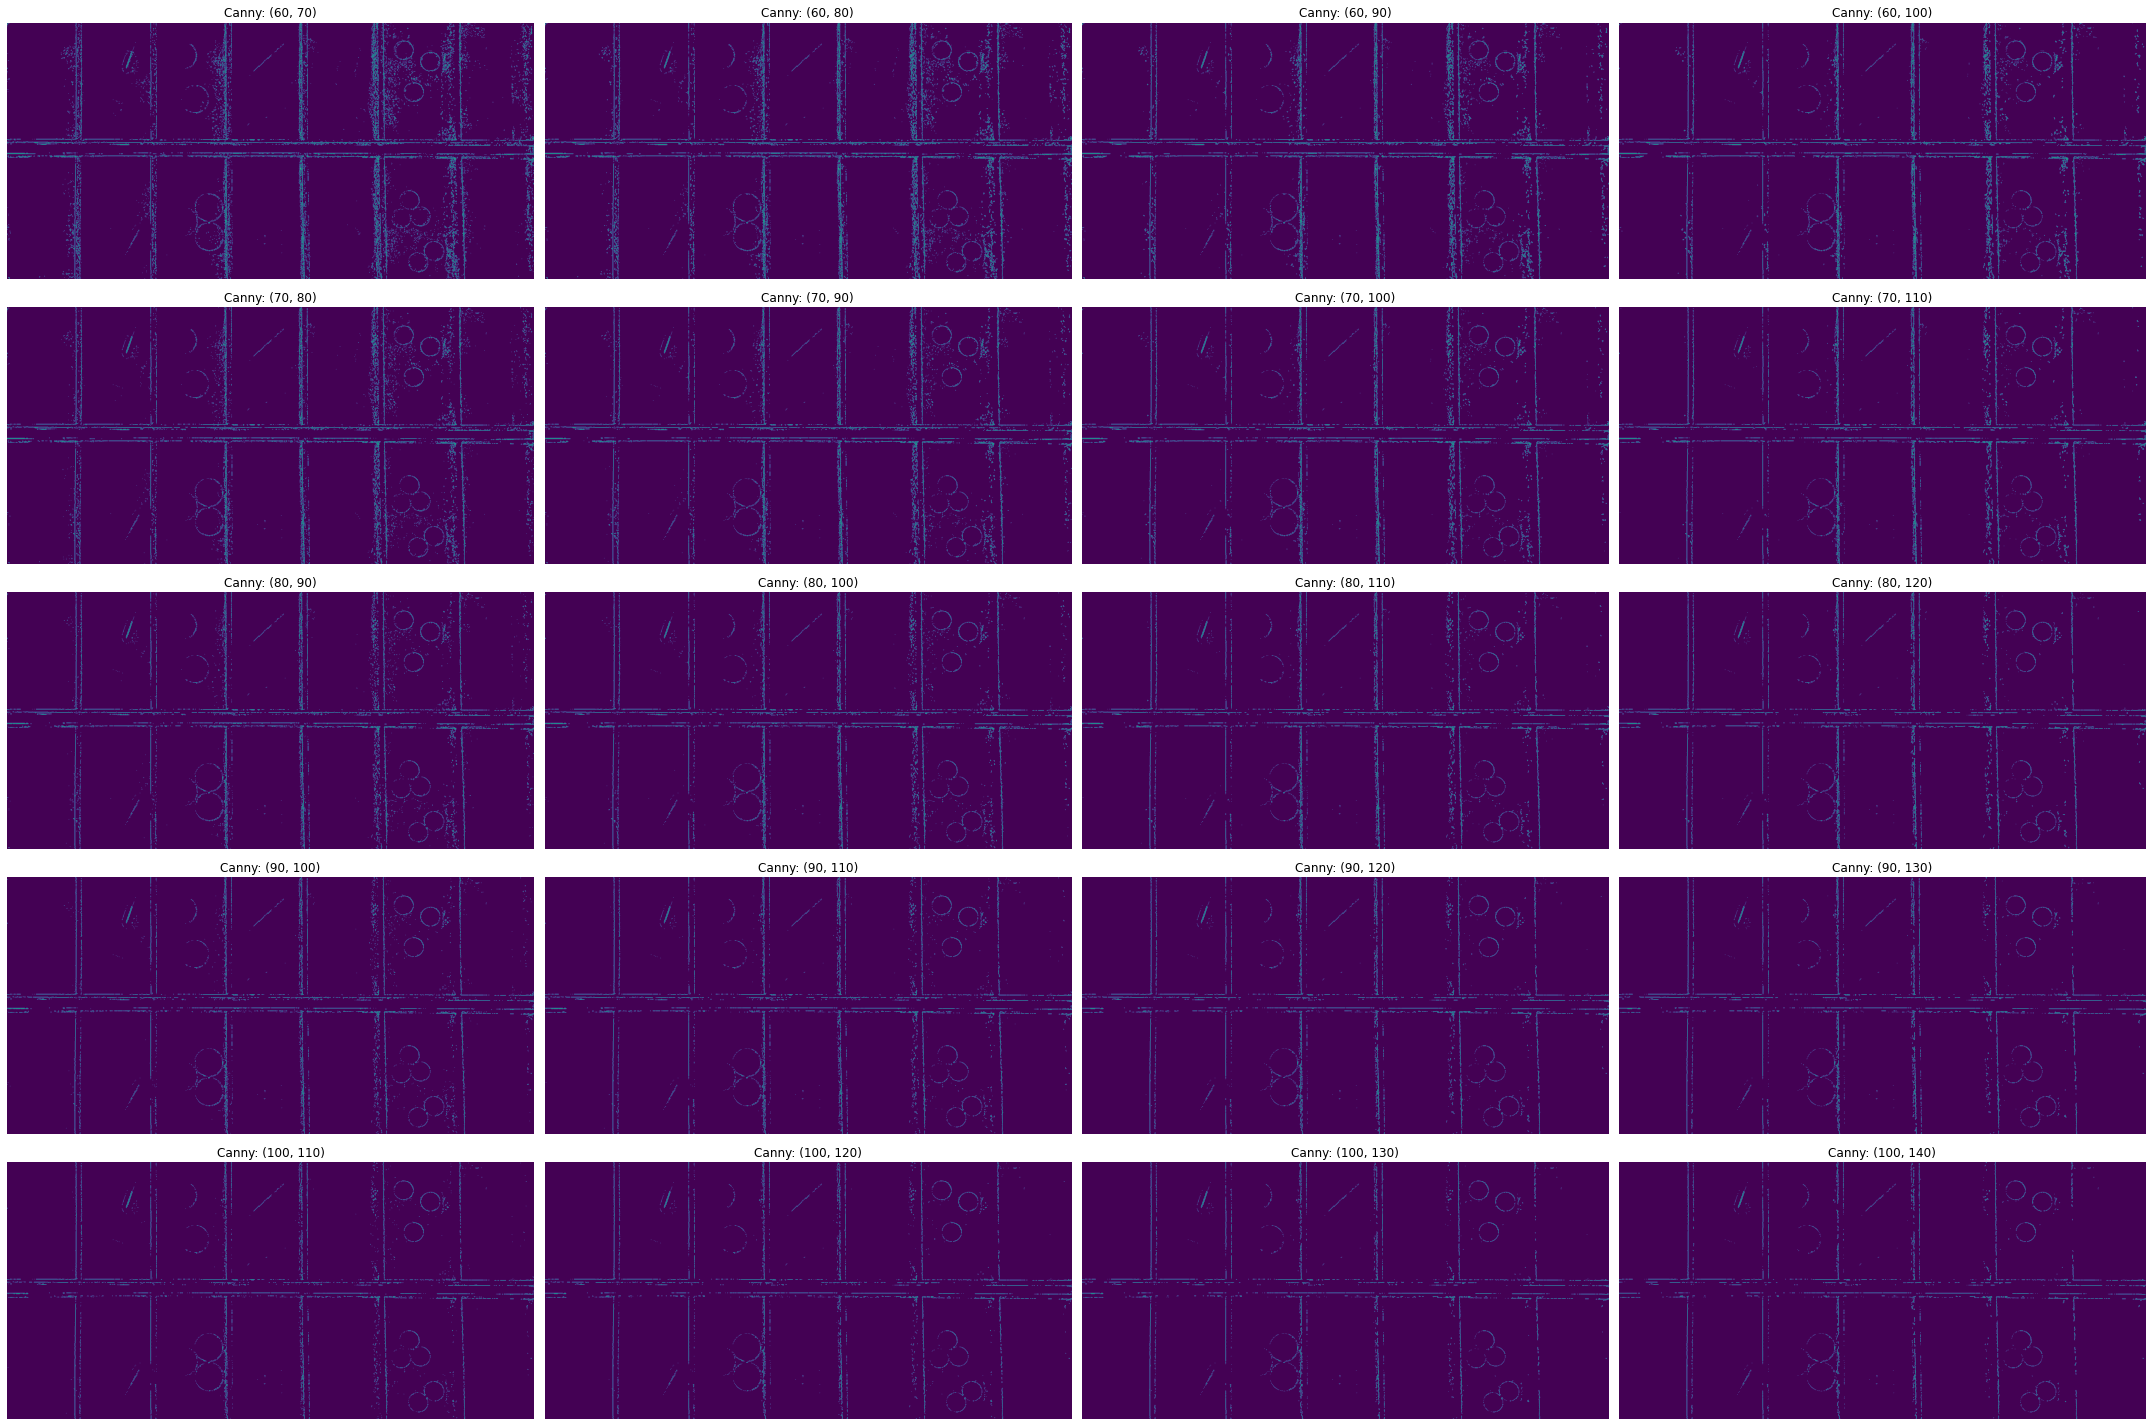

In [80]:
plot_canny_ablation(pills_v, pills_mask)

Najlepszym doborem parametrów canny wydaje się (80, 100) oraz sprogowane tabletki na 200 jako maska do filtracji.

In [81]:
def plot_hough_acc_resolution(img, canny, threshold):
    rhos = [0.05, 0.1, 0.5, 1]
    thetas = [np.pi / 2, np.pi / 6, np.pi / 18, np.pi / 36, np.pi / 72]

    fig, axes = plt.subplots(len(thetas), len(rhos), figsize=(30, 20))

    for theta, axi in zip(thetas, axes):
        for rho, ax in zip(rhos, axi):
            lines = cv2.HoughLines(canny, rho, theta, threshold)
            image_lines = img.copy()

            for line in lines:
                x1, y1, x2, y2 = rhotheta2xy(line) 
                cv2.line(image_lines, (x1, y1), (x2, y2), (0,0,255), 2)

            ax.imshow(image_lines[..., ::-1])
            ax.set_title(f"Hough: θ={180 * (theta / np.pi)}°, ρ={rho}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

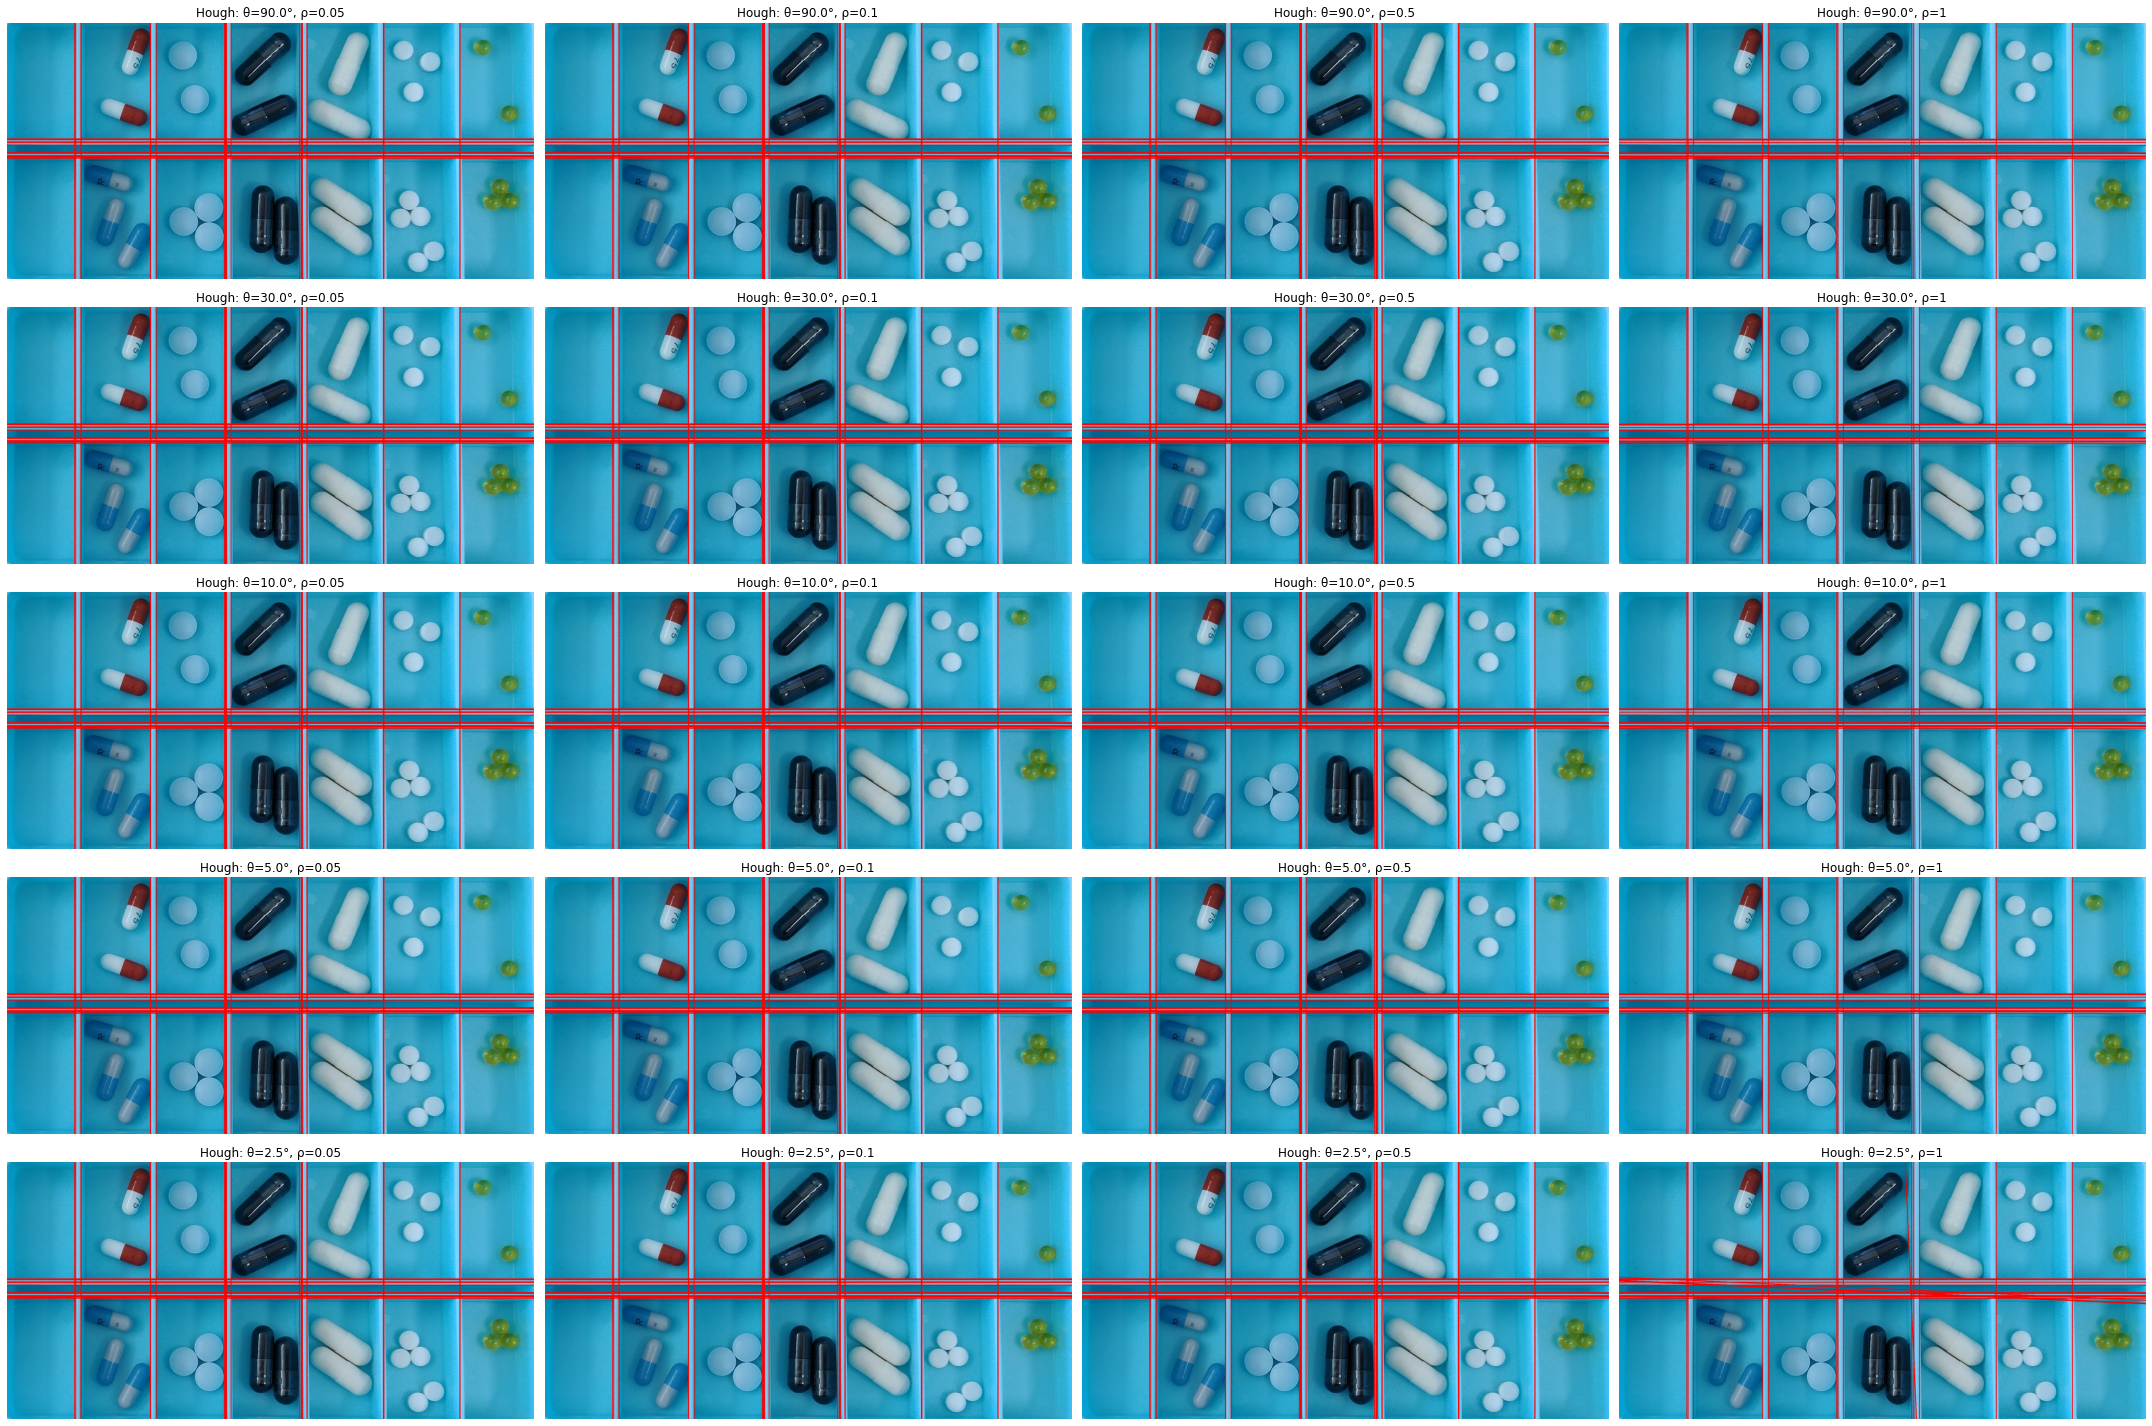

In [82]:
pills_canny = cv2.Canny(pills_v, threshold1=80, threshold2=100)
pills_canny = pills_canny * (pills_v > 200)

plot_hough_acc_resolution(pills_c, pills_canny, 100)

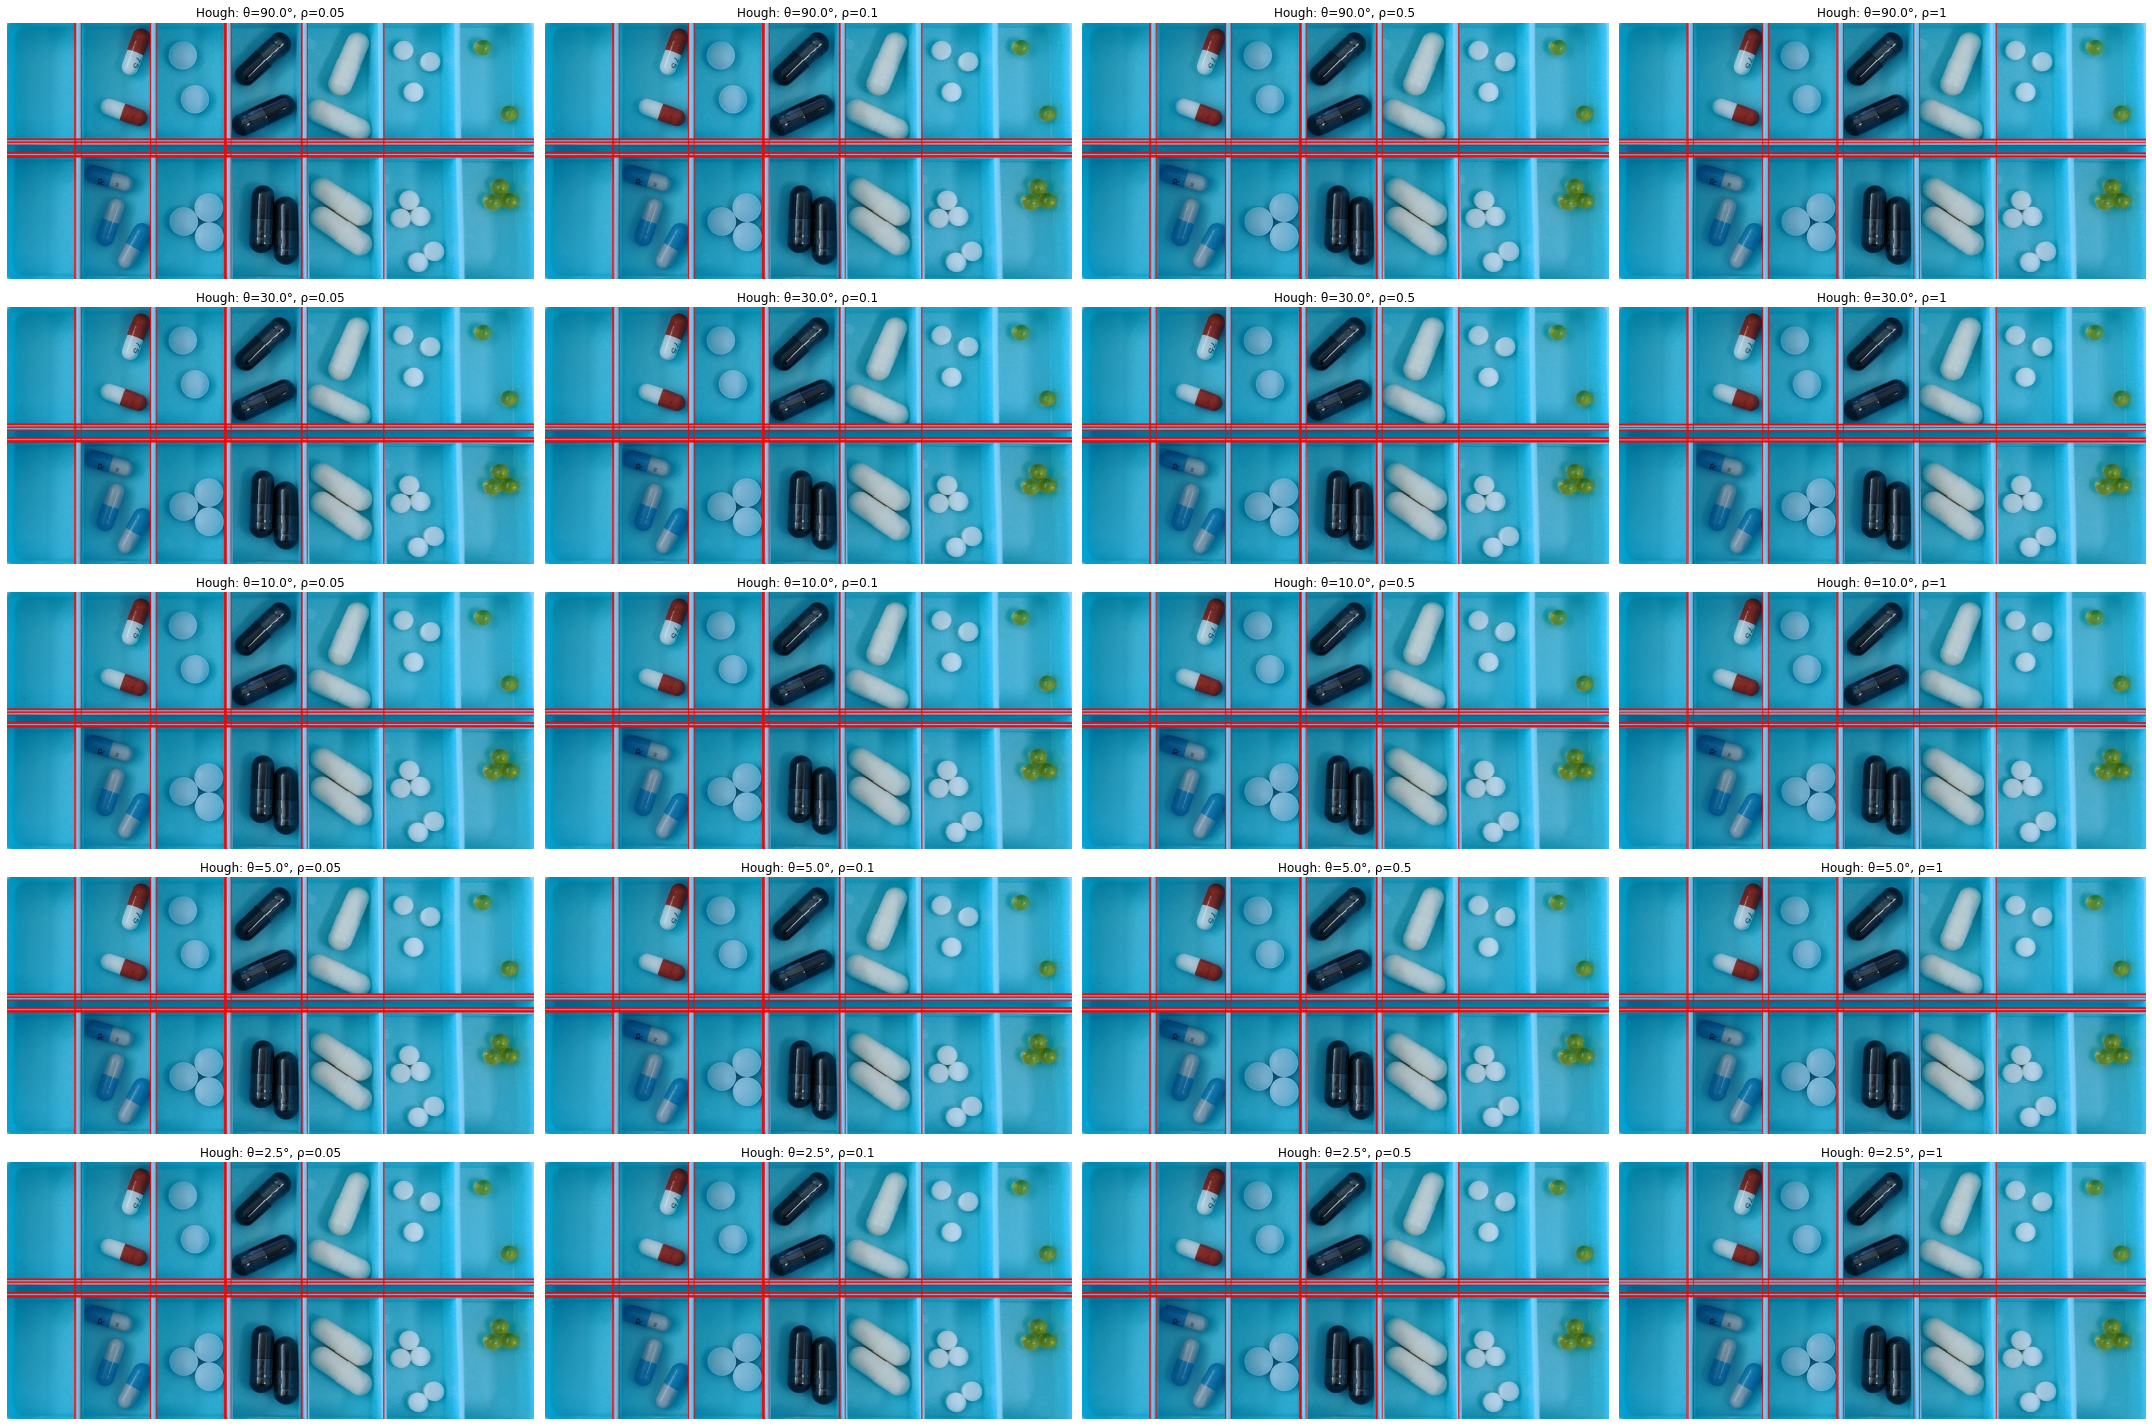

In [83]:
plot_hough_acc_resolution(pills_c, pills_canny, 120)

* Dla progu 120 zaczynamy gubić prawą krawędź
* Dla mniejszych wartości kąta poziome linie "przeskakują"

#### Zadanie dodatkowe (dla chętnych)

Dany jest obraz `coins`. Celem jest (1) przebadanie wpływu parametrów funkcji [`cv2.HoughCircles`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d) na znajdowane okręgi oraz (2) wykorzystanie transformacji Hougha do zliczenia monet znajdujących się na obrazie. Jak poprzednio, zacznij od uzyskania dobrej jakości detekcji krawędzi - natychmiast zauważysz, że im więcej na obrazie zakłóceń (tj. krawędzi nie będących interesującymi nas okręgami), tym gorsze będą rezultaty transformacji Hougha.  
Aby wyznaczyć sensowne wartości początkowe parametrów `HoughCircles`, przyjrzyj się geometrii obrazu - "na oko" przyjmij wartości `minDist`, `minRadius` i `maxRadius`; wybierz metodę `cv2.HOUGH_GRADIENT`, załóż $dp=1.5$ i przy tych wartościach znajdź wartość `param2`. Jeśli twój detektor krawędzi działa dobrze, parametr `param1` możesz wtedy pominąć.

Zwróć uwagę, że `cv2.HoughCircles` zwraca wynik w postaci zmiennoprzecinkowej `np.ndarray` o 3 wymiarach: (1, N, 3) gdzie N to liczba wykrytych okręgów a trójka liczb w ostatnim wymiarze odpowiada parametrom *x, y, r* wykrytego okręgu.

Zaprezentuj ostateczny wynik tak jak w zadaniu 1; do narysowania okręgów wykorzystaj funkcję [`cv2.circle`](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670) (pamiętaj, że oczekuje parametrów okręgu jako liczby całkowite!).

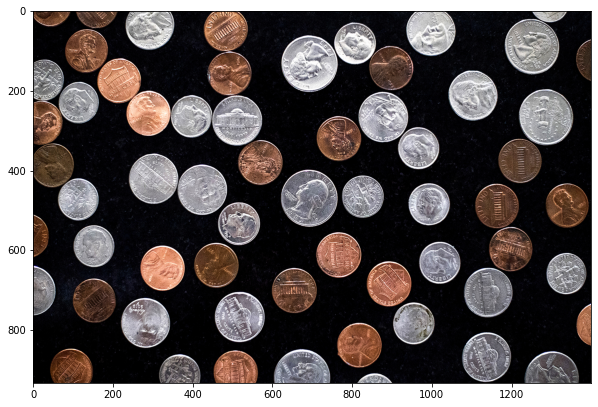

In [36]:
coins = cv2.imread('Coins.jpg')
plt.imshow(coins[..., ::-1]);
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

Rozwiązanie: